# select test data from synthetic data
by selecting galaxies inside the observation's support

In [1]:
import os
import numpy as np 

In [2]:
import torch
from torch import optim
from nflows import transforms, distributions, flows

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [11]:
seed = 0 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda: torch.cuda.manual_seed(seed)

# import observations

In [5]:
dat_dir = '/scratch/network/chhahn/sedflow/'
obs_enc_spec = np.load(os.path.join(dat_dir, 'sedflow_p.obs.v0.1.encoded.npy'))
obs_enc_ivar = np.load(os.path.join(dat_dir, 'sedflow_p.obs.v0.1.ivar.encoded.npy'))
obs_zred = np.load(os.path.join(dat_dir, 'sedflow_p.obs.v0.1.zred.npy'))

In [6]:
obs_data = np.concatenate([obs_enc_spec, obs_enc_ivar, obs_zred[:,None]], axis=1)

# import test data

In [8]:
test_theta_sps = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.theta_sps.npy'))
test_theta_unt = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.theta_unt.npy'))
test_enc_spec = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.encoded.npy'))
test_enc_ivar = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.ivar.encoded.npy'))
test_zred = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.zred.npy'))

In [9]:
test_data = np.concatenate([test_enc_spec, test_enc_ivar, test_zred[:,None]], axis=1)

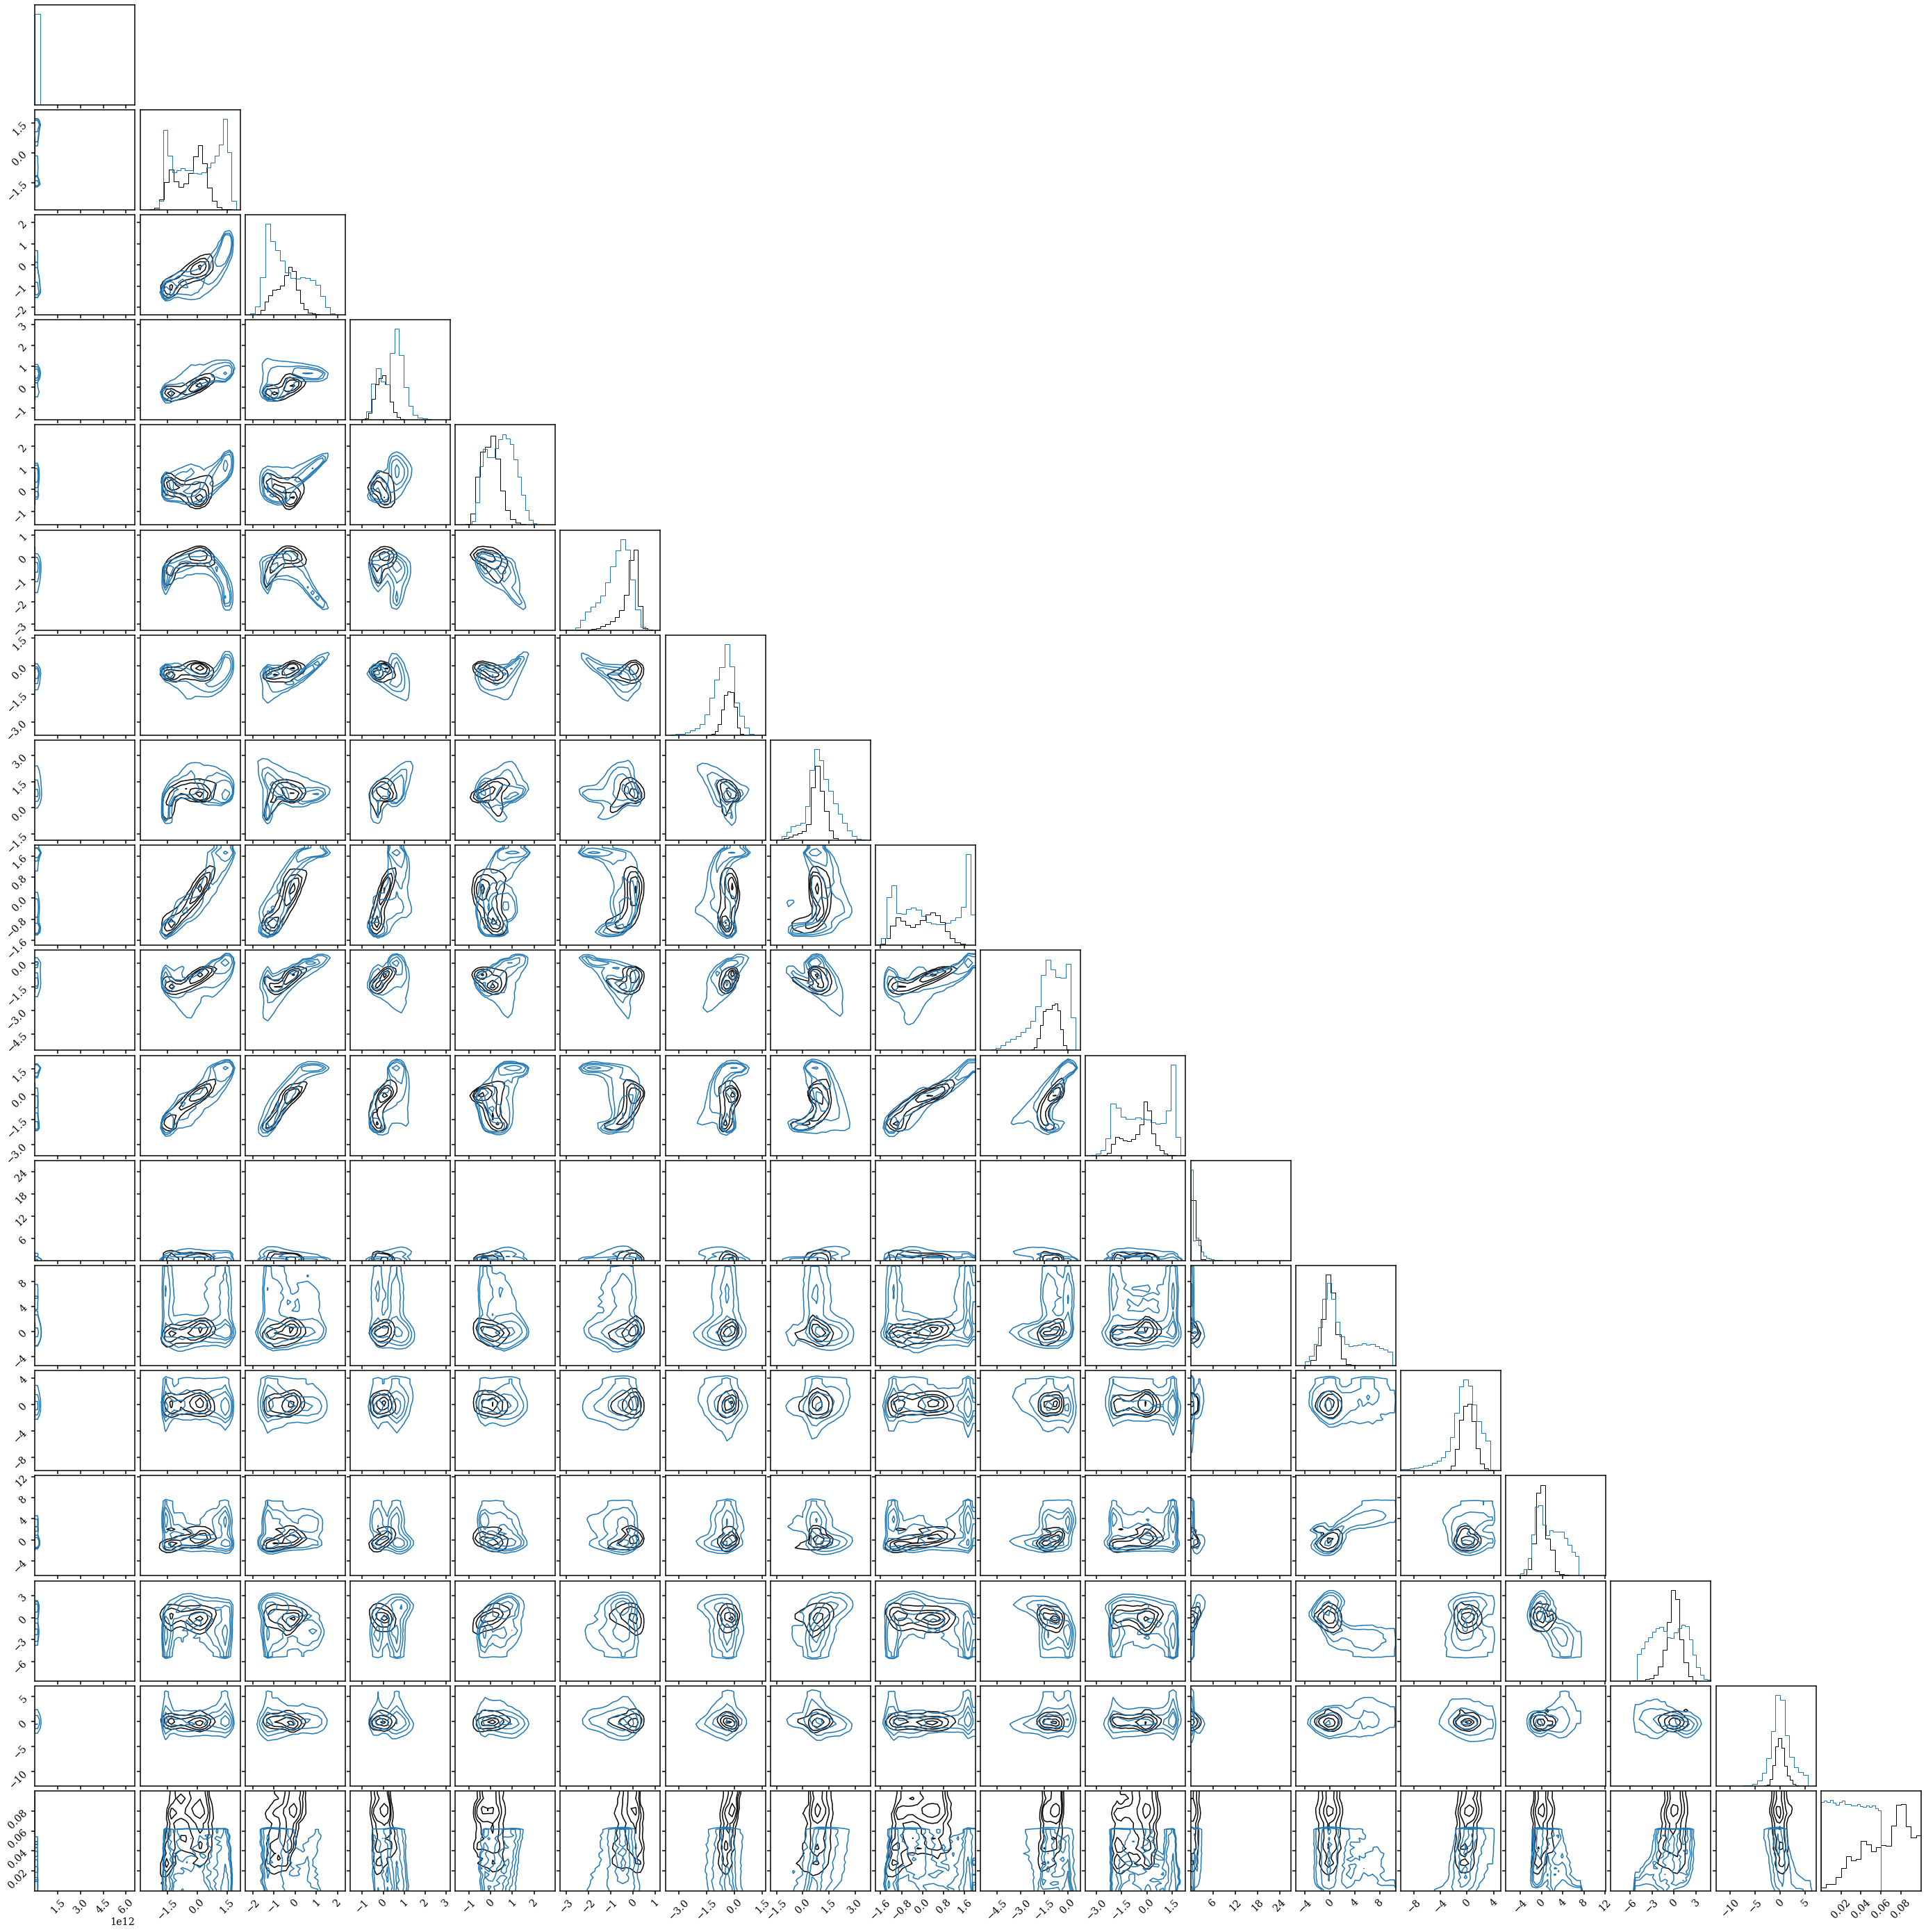

In [10]:
fig = DFM.corner(obs_data, plot_datapoints=False, plot_density=False)
_ = DFM.corner(test_data, plot_datapoints=False, plot_density=False, color='C0', fig=fig)

# train NDE on observations

In [13]:
ndim = obs_data.shape[1]
Ntrain = int(0.9 * obs_data.shape[0])
train_loader = torch.utils.data.DataLoader(
        torch.tensor(obs_data[:Ntrain].astype(np.float32)).to(device), 
        batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
        torch.tensor(obs_data[Ntrain:].astype(np.float32)).to(device), 
        batch_size=512, shuffle=False)

In [14]:
all_flows, all_archs, all_valid_losses = [], [], []
for i in range(5): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))
    nblocks = int(np.random.uniform(3, 7))
    all_archs.append('%ix%i' % (nhidden, nblocks))

    blocks = []
    for iblock in range(nblocks): 
        blocks += [transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
                transforms.RandomPermutation(features=ndim)]
    transform = transforms.CompositeTransform(blocks)

    base_distribution = distributions.StandardNormal(shape=[ndim])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    num_iter = 1000
    patience = 20

    optimizer = optim.Adam(flow.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 1e-3, total_steps=num_iter)

    best_epoch, best_valid_loss, valid_losses = 0, np.inf, []
    for epoch in range(num_iter):
        train_loss = 0.
        for batch in train_loader: 
            optimizer.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss = train_loss/float(len(train_loader))

        with torch.no_grad():
            valid_loss = 0.
            for batch in valid_loader: 
                loss = -flow.log_prob(batch).mean()
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_loader)
            valid_losses.append(valid_loss)

            if epoch % 20 == 0: print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
            scheduler.step()

    all_flows.append(flow)
    all_valid_losses.append(valid_losses)

0 	 3.46e+16 	 3.04e+18
20 	 1.83e+10 	 3.03e+16
>>>25 	 7.45423e+15
0 	 1.91e+03 	 1.86e+04
20 	 3.78e+01 	 2.66e+02
40 	 2.50e+01 	 2.81e+01
60 	 1.22e+01 	 1.19e+01
80 	 7.62e+00 	 7.66e+00
100 	 5.93e+00 	 5.71e+00
120 	 4.77e+00 	 4.59e+00
140 	 4.03e+00 	 3.83e+00
160 	 3.44e+00 	 3.07e+00
180 	 2.92e+00 	 2.81e+00
200 	 2.82e+00 	 2.51e+00
220 	 2.09e+00 	 2.05e+00
240 	 1.74e+00 	 1.79e+00
260 	 1.42e+00 	 1.83e+00
280 	 1.18e+00 	 1.10e+00
300 	 9.45e-01 	 1.07e+00
320 	 7.85e-01 	 9.28e-01
340 	 6.00e-01 	 7.10e-01
360 	 4.54e-01 	 6.71e-01
>>>378 	 4.99500e-01
0 	 2.18e+19 	 4.50e+19
20 	 1.86e+20 	 8.20e+13
40 	 6.32e+19 	 7.63e+20
>>>46 	 6.73215e+13
0 	 1.44e+02 	 2.45e+03
20 	 1.75e+01 	 1.68e+01
40 	 7.54e+00 	 7.04e+00
60 	 5.16e+00 	 4.83e+00
80 	 4.07e+00 	 3.82e+00
100 	 3.18e+00 	 2.94e+00
120 	 2.55e+00 	 2.19e+00
140 	 2.09e+00 	 1.78e+00
160 	 1.68e+00 	 1.65e+00
180 	 1.40e+00 	 1.47e+00
200 	 1.19e+00 	 1.18e+00
>>>200 	 1.15230e+00
0 	 1.14e+07 	 1.57e+06
20 

In [15]:
ibest = np.argmin([np.min(vl) for vl in all_valid_losses])
best_flow = all_flows[ibest]
best_arch = all_archs[ibest]

In [16]:
with torch.no_grad(): 
    nde_samples = best_flow.sample(10000)

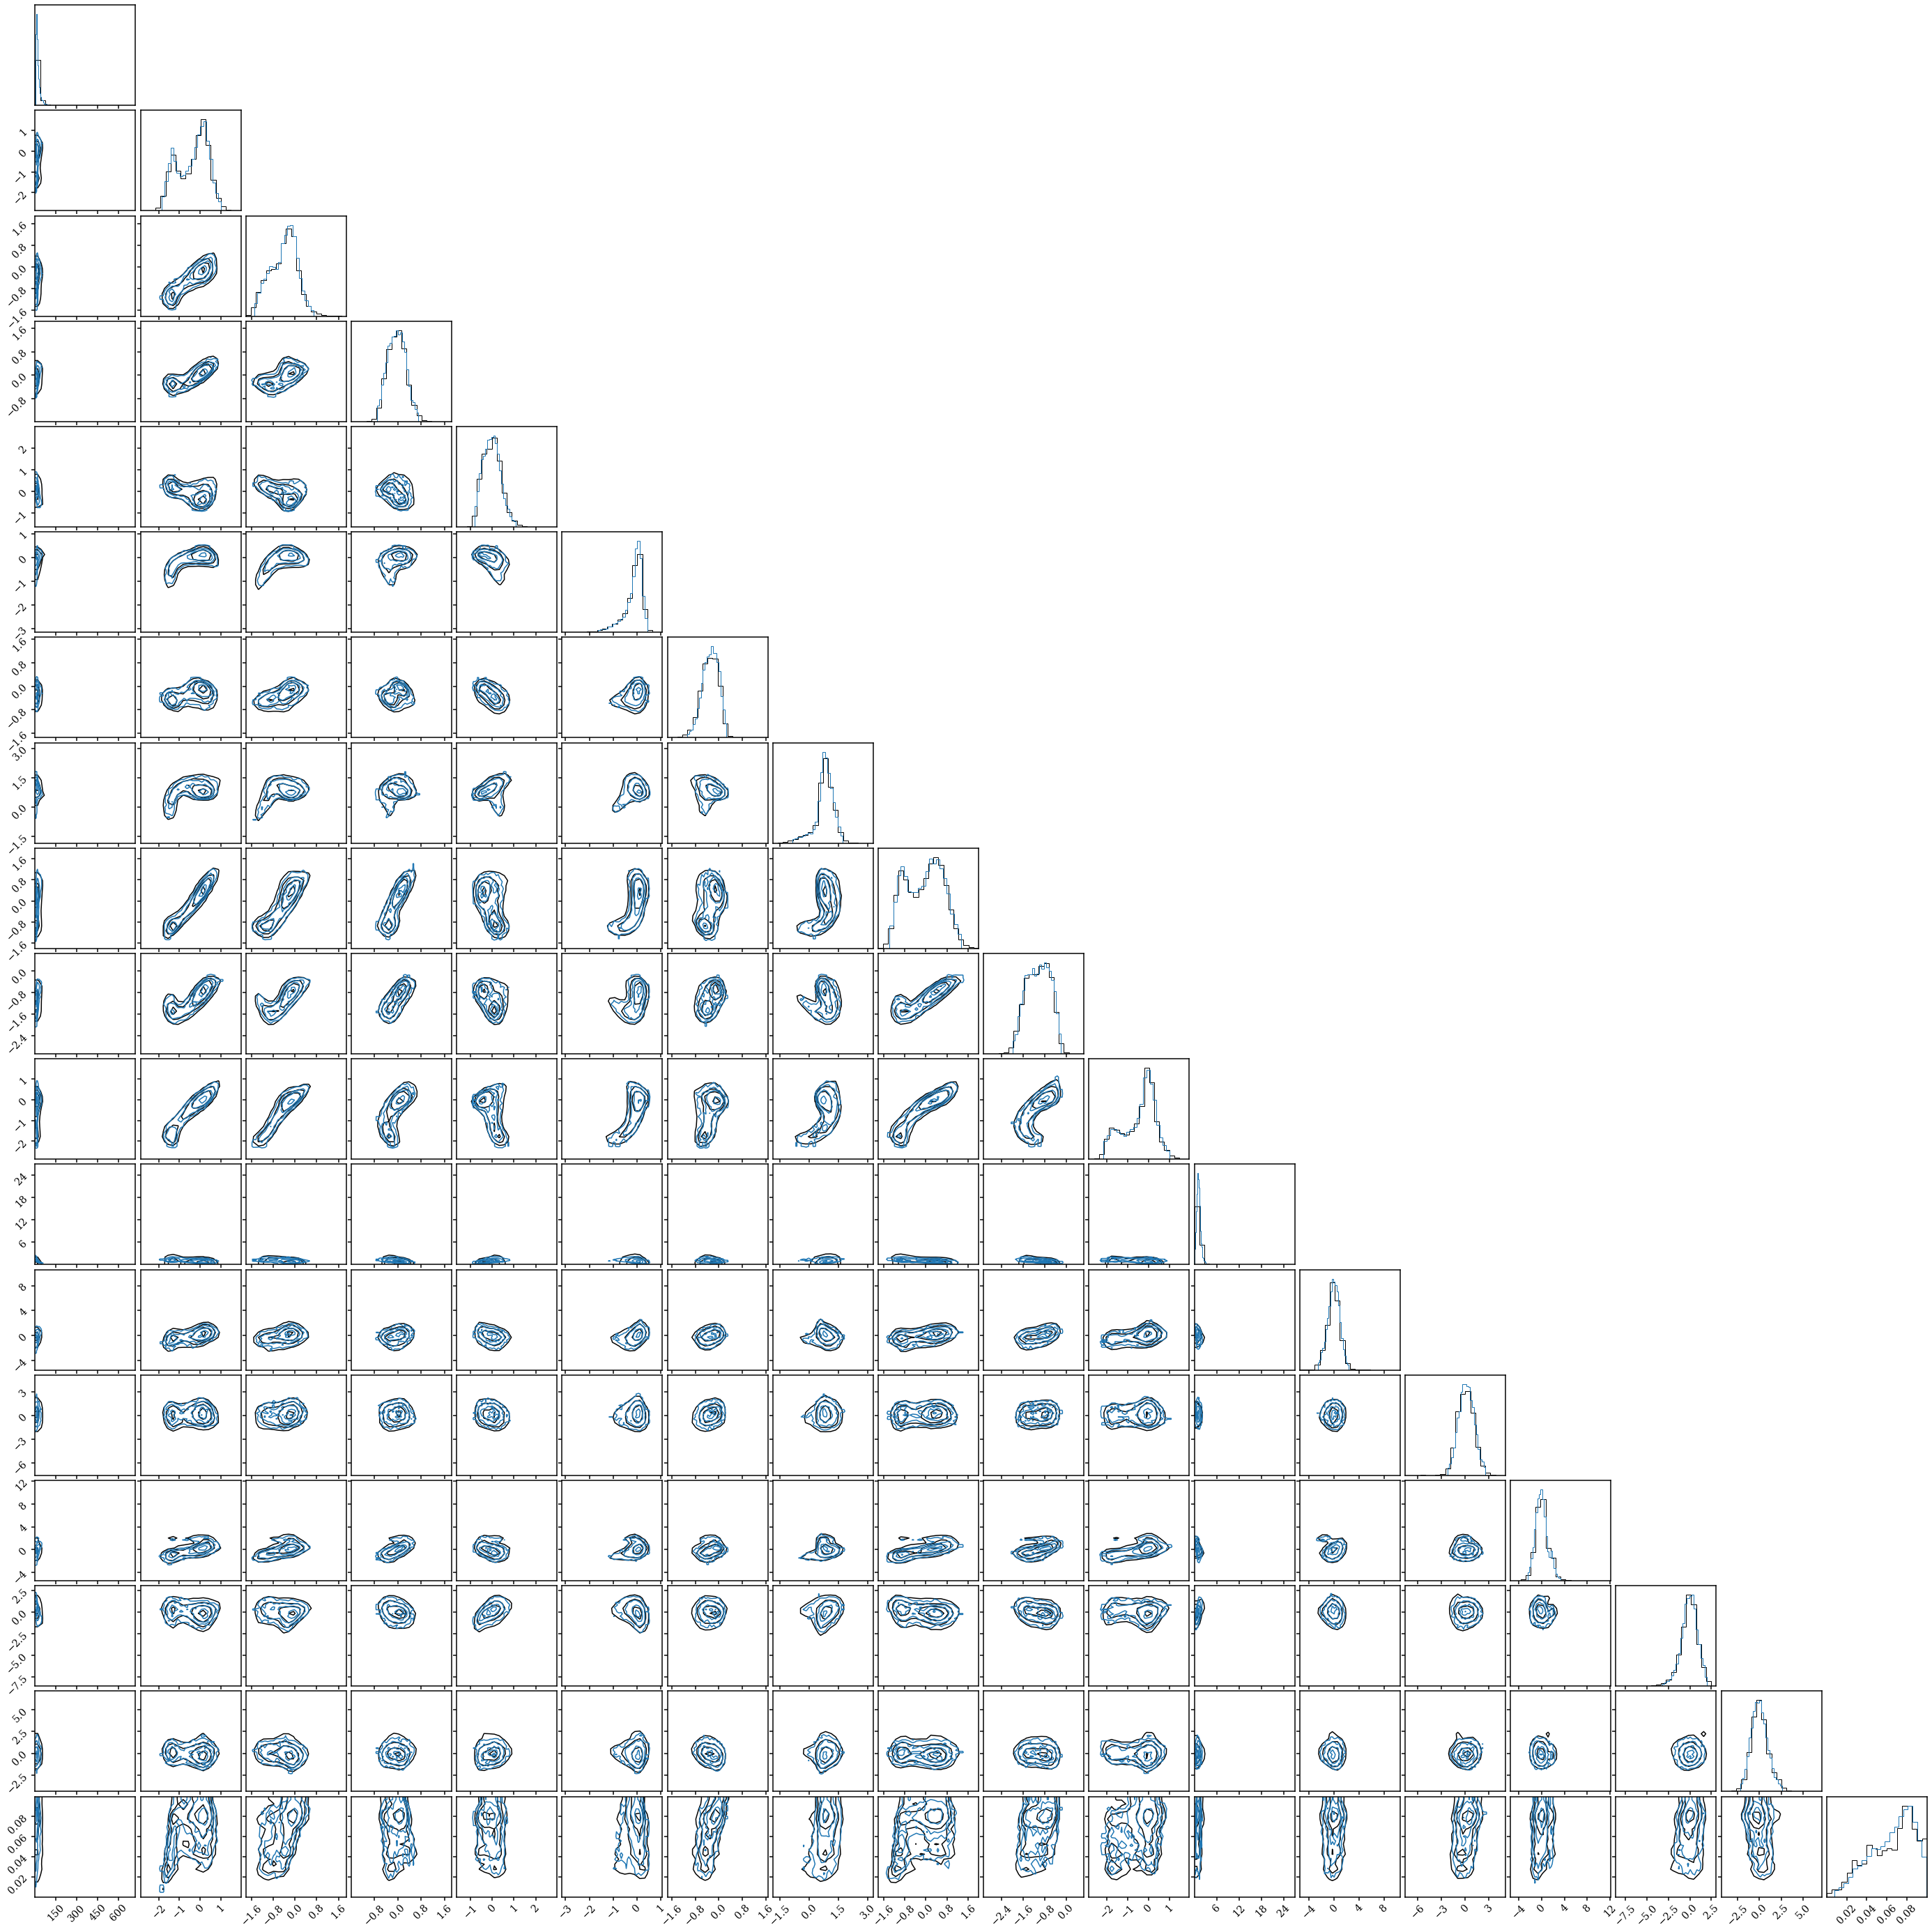

In [17]:
fig = DFM.corner(obs_data,
                 hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)
_ = DFM.corner(np.array(nde_samples.detach().cpu()), color='C0', 
               range=[np.nanquantile(obs_col, [0.01, 0.99]) for obs_col in obs_data.T],
               hist_kwargs={'density': True},
               plot_datapoints=False, plot_density=False, fig=fig)

# Use NDE to only keep test data within observations

In [21]:
test_loader = torch.utils.data.DataLoader(
    torch.tensor(test_data.astype(np.float32)).to(device), 
    batch_size=512, shuffle=False)

with torch.no_grad(): 
    test_logprob = []
    for batch in test_loader: 
        logprob = best_flow.log_prob(batch)
        test_logprob.append(np.array(logprob.detach().cpu()))
test_logprob = np.concatenate(test_logprob)

In [40]:
logprob_cut = (test_logprob > -10)

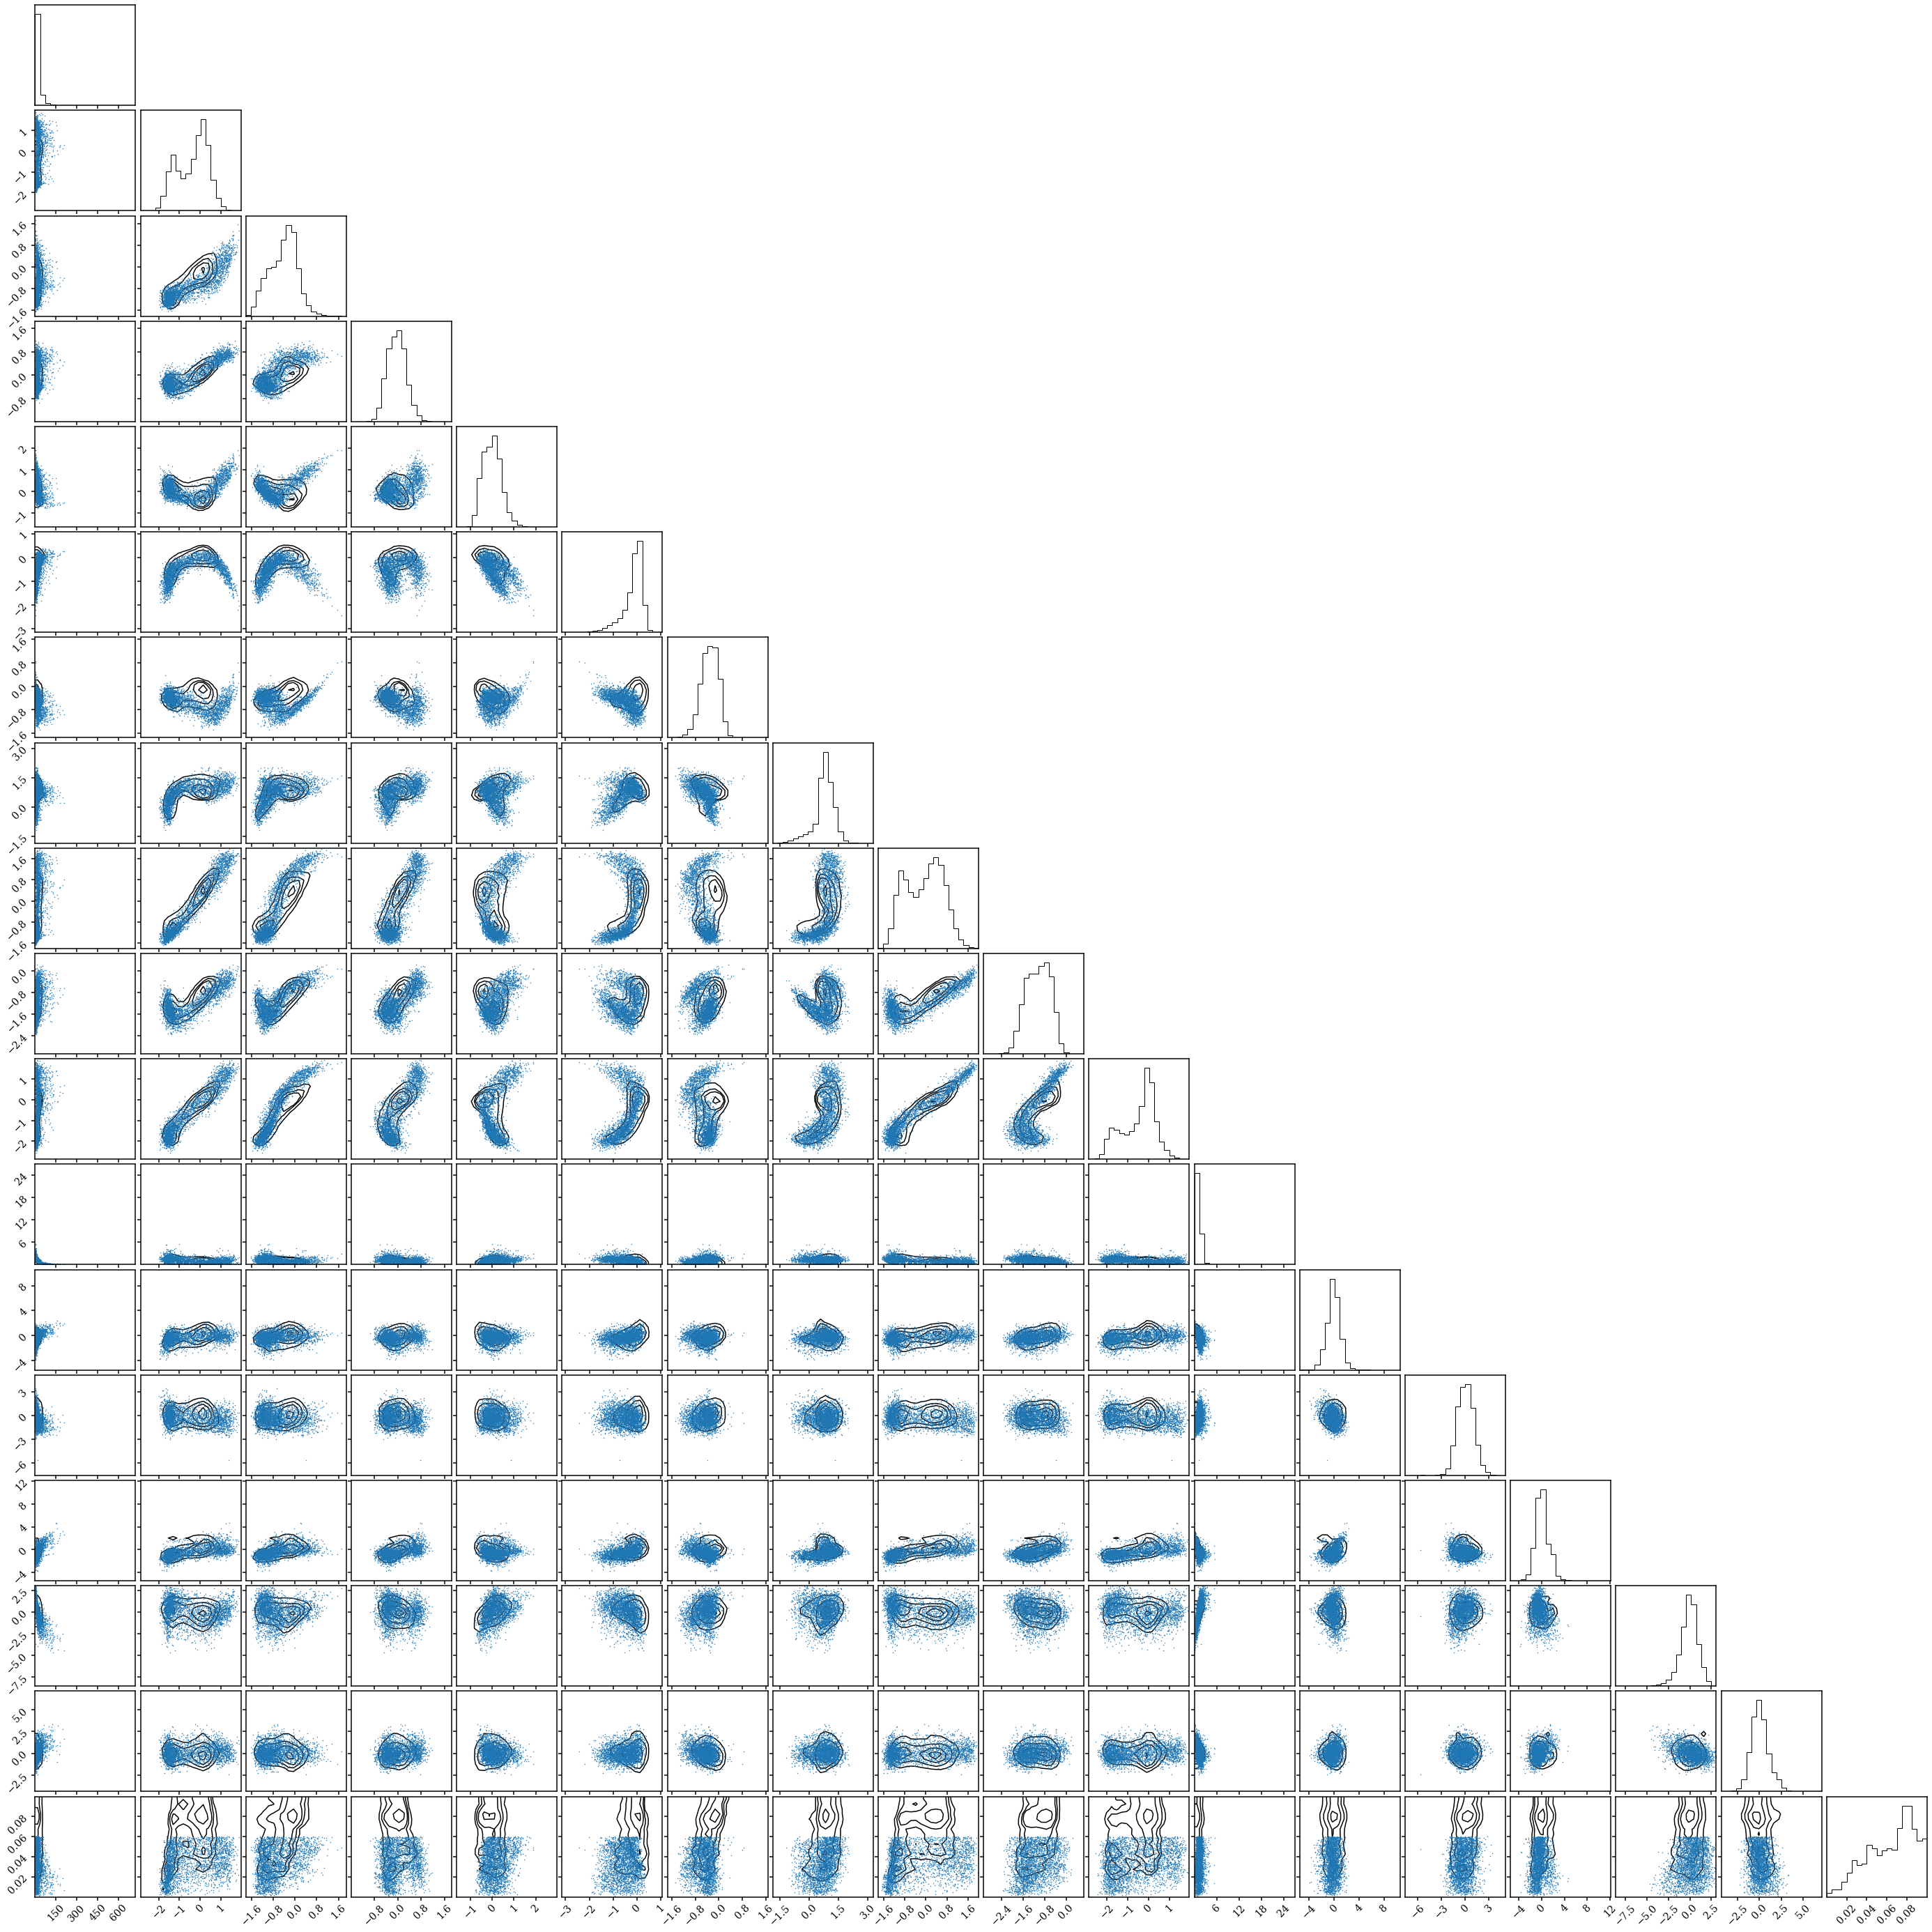

In [41]:
fig = DFM.corner(obs_data,
                 hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)
DFM.overplot_points(fig, test_data[logprob_cut], color='C0', markersize=1)

In [43]:
np.save(os.path.join(dat_dir, 'sedflow_p.test_inobs.v0.1.theta_sps.npy'), test_theta_sps[logprob_cut])
np.save(os.path.join(dat_dir, 'sedflow_p.test_inobs.v0.1.theta_unt.npy'), test_theta_unt[logprob_cut])

np.save(os.path.join(dat_dir, 'sedflow_p.test_inobs.v0.1.encoded.npy'), test_enc_spec[logprob_cut])
np.save(os.path.join(dat_dir, 'sedflow_p.test_inobs.v0.1.ivar.encoded.npy'), test_enc_ivar[logprob_cut])
np.save(os.path.join(dat_dir, 'sedflow_p.test_inobs.v0.1.zred.npy'), test_zred[logprob_cut])